# **Deep Neural Network from scratch**

**In this project i will implement Neural Network to recognite handwritten digit**:

*   The dataset for this project would be MNIST handwritten digit dataset
*   I can not use any frameworks related to deep learning in this project



In [29]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
train = pd.read_csv('/content/drive/MyDrive/Projects/Digit Recognition/Dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Projects/Digit Recognition/Dataset/test.csv')


## **Prepare Data**

In [98]:
# Split training data in to X and y
X = train.iloc[:, 1:].values
y = train.iloc[:, 0].values.reshape(-1, 1)

# I will also preprocess the test set with respect to trainning set for submission
test = test.values.T

# Normalizing data
X = X / 255.
test = test / 255.

((42000, 784), (42000, 1), (784, 28000))

In [99]:
# Split the training data into 2 (Train set and validation set)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.24, random_state= 42)

# Transpose X_train, X_val, y_train, y_val --> We want the dimension to be (n, m) where n are pixels and m are examples
X_train, X_val = X_train.T, X_val.T
y_train, y_val = y_train.reshape(1, -1), y_val.reshape(1, -1)

# Check for the shape
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((784, 31920), (1, 31920), (784, 10080), (1, 10080))

## **Model development**

In [110]:
# Specify layers for Neural Networks
n_x, n_h1, n_h2, n_y = X_train.shape[0], 64, 32, 10

# Initialize parameters for Neural Networks
def initialize_params(n_x, n_h1, n_h2, n_y):
    W1 = np.random.randn(n_h1, n_x) * np.sqrt(2. / n_x) # Applying'He Initialization" initialize method which help gradient descent converge faster
    b1 = np.zeros((n_h1, 1))
    W2 = np.random.randn(n_h2, n_h1) * np.sqrt(2. / n_h1)
    b2 = np.zeros((n_h2, 1))
    W3 = np.random.randn(n_y, n_h2) * np.sqrt(2. / n_h2)
    b3 = np.zeros((n_y, 1))

    parameters = {'W1': W1, 'b1': b1,   # Store all parameters in a dictionary
                  'W2': W2, 'b2': b2,
                  'W3': W3, 'b3': b3}

    return parameters


# I will also write out the activation functions for forward propagation step -> ReLU for hidden layers and softmax for output layer

@staticmethod
def ReLU(Z):
    return np.maximum(0, Z)

@staticmethod
def ReLU_derivative(Z):
    return Z > 0

@staticmethod
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0))  # for numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

@staticmethod
def one_hot_encoded(y, n_y=10):         # We also need to one hot encode Y
    one_hot_y = np.zeros((n_y, y.size))
    one_hot_y[y, np.arange(y.size)] = 1
    return one_hot_y


def forward_prop(parameters, X):                # Forward propagation step
    W1, b1 = parameters['W1'], parameters['b1']
    W2, b2 = parameters['W2'], parameters['b2']
    W3, b3 = parameters['W3'], parameters['b3']

    Z1 = np.dot(W1, X) + b1
    A1 = ReLU(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = ReLU(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)

    cache = {'Z1': Z1, 'A1': A1, # Store all answers in a dictionary
             'Z2': Z2, 'A2': A2,
             'Z3': Z3, 'A3': A3}

    return A3, cache


def cross_entropy(A3, y):    # For multi-class classification i will use cross entropy to calculate the cost for each examples
    m = A3.shape[1]
    cost = - np.sum(y * np.log(A3 + 1e-8)) / m
    cost = np.squeeze(cost)
    return cost


def back_prop(parameters, cache, X, y):          # Back propagation step
    m = y.shape[1]
    W3, W2 = parameters['W3'], parameters['W2']
    Z1, A1 = cache['Z1'], cache['A1']
    Z2, A2 = cache['Z2'], cache['A2']
    A3 = cache['A3']

    one_hot_y = one_hot_encoded(y)

    dZ3 = A3 - one_hot_y
    dW3 = np.dot(dZ3, A2.T) / m
    db3 = np.sum(dZ3, axis=1, keepdims=True) / m
    dZ2 = np.dot(W3.T, dZ3) * ReLU_derivative(Z2)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    dZ1 = np.dot(W2.T, dZ2) * ReLU_derivative(Z1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    grads = {'dW3': dW3, 'db3': db3,
             'dW2': dW2, 'db2': db2,
             'dW1': dW1, 'db1': db1}

    return grads


def update_params(grads, parameters, learning_rate): # After calculate gradients i will use it to update all parameters
    for param in parameters:
        parameters[param] -= learning_rate * grads['d' + param]
    return parameters


def DeepNeuralNetworks(X, y, iters, learning_rate, n_x, n_h1, n_h2, n_y): # Now putting all together in one function
    parameters = initialize_params(n_x, n_h1, n_h2, n_y)
    one_hot_y = one_hot_encoded(y)

    for i in range(iters):
        A3, cache = forward_prop(parameters, X)
        cost = cross_entropy(A3, one_hot_y)
        if i % 10 == 0:
            print(f'Cost at iteration {i}: {cost:.5f}')
        grads = back_prop(parameters, cache, X, y)
        parameters = update_params(grads, parameters, learning_rate)
    return parameters



def predict(updated_parameters, X):  # Define a predict function
    predictions, _ = forward_prop(updated_parameters, X)
    return np.argmax(predictions, axis= 0)

def score(predictions, y): # Define a score function to get the accuracy
    score = np.mean(predictions == y)
    return score


updated_parameters = DeepNeuralNetworks(X_train, y_train, iters=4500, learning_rate=0.075, n_x=n_x, n_h1=n_h1, n_h2=n_h2, n_y=n_y) # Train the model
y_preds = predict(updated_parameters, X_train)
accuracy = score(y_preds, y_train)

print(f'Accuracy: {accuracy:.2f} %')

Cost at iteration 0: 2.41395
Cost at iteration 10: 2.00804
Cost at iteration 20: 1.55639
Cost at iteration 30: 1.14564
Cost at iteration 40: 0.87345
Cost at iteration 50: 0.71885
Cost at iteration 60: 0.62423
Cost at iteration 70: 0.56072
Cost at iteration 80: 0.51508
Cost at iteration 90: 0.48060
Cost at iteration 100: 0.45356
Cost at iteration 110: 0.43172
Cost at iteration 120: 0.41368
Cost at iteration 130: 0.39849
Cost at iteration 140: 0.38546
Cost at iteration 150: 0.37414
Cost at iteration 160: 0.36421
Cost at iteration 170: 0.35541
Cost at iteration 180: 0.34751
Cost at iteration 190: 0.34036
Cost at iteration 200: 0.33385
Cost at iteration 210: 0.32787
Cost at iteration 220: 0.32236
Cost at iteration 230: 0.31726
Cost at iteration 240: 0.31252
Cost at iteration 250: 0.30809
Cost at iteration 260: 0.30393
Cost at iteration 270: 0.30002
Cost at iteration 280: 0.29632
Cost at iteration 290: 0.29281
Cost at iteration 300: 0.28948
Cost at iteration 310: 0.28630
Cost at iteration 3

## **Evaluation**

In [112]:
y_train_preds = predict(updated_parameters, X_train)
accuracy = score(y_train_preds, y_train)
print(f'Accuracy on training set: {accuracy}')

y_val_preds = predict(updated_parameters, X_val)
accuracy = score(y_val_preds, y_val)
print(f'Accuracy on validation set: {accuracy}')

Accuracy on training set: 0.9886591478696742
Accuracy on validation set: 0.9638888888888889




*  The training set does slighly better than the validation set only 2% which i think the model is not really overfitting
*  The Neural Networks model perform really well on recognizing image




Prediction: [2]
Label: [[2]]


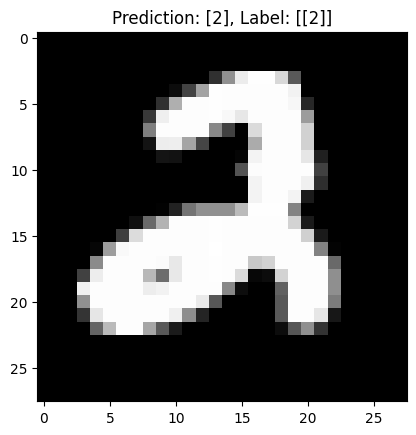

In [195]:
def plot_prediction(index, updated_parameters, X, y): # Plot to see the result on validation set

    image = X[:, index, None]
    prediction = predict(updated_parameters, image)
    label = y[:, index, None]

    print(f'Prediction: {prediction}')
    print(f'Label: {label}')

    image = image.reshape((28, 28)) * 255

    plt.gray()
    plt.imshow(image, interpolation ='nearest')
    plt.title(f'Prediction: {prediction}, Label: {label}')
    plt.show()


plot_prediction(4544, updated_parameters, X_val, y_val)

In [189]:
}# I create this cell only for submission
predictions = predict(updated_parameters, test)

col_name = ['Label']
submission = pd.DataFrame(predictions, columns= col_name )

submission.index = submission.index + 1
submission.index.name = 'ImageId'
submission.reset_index(inplace= True)

submission.to_csv('/content/submit/submission.csv', index= False)